# Connect to Google Drive

reference: https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

Archived: https://web.archive.org/web/20210118012346/https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
import tensorflow.keras
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
!pip install mlxtend==0.16.0
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Set Variables for Experiment

In [ ]:
model_name = 'basic_blstm.h5'
classes = ['car', 'leisure', 'play', 'run_jog', 'seizure', 'sleep', 'walk']
frame_seconds = 4
hop_seconds = 4
Fs = 20
frame_size = Fs * frame_seconds 
hop_size = Fs * hop_seconds

# Load in Cleaned Dataset

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Smart Dog Collar/Data/03-31-2021_snapshot/cleaned_data.csv')
display(df)

,g_x,g_y,g_z,a_x,a_y,a_z,label
0,1.196273,-1.081498,1.421736,-0.073822,-1.294081,0.425378,6
1,0.395422,-0.997478,0.547428,0.546037,-0.524955,-1.332338,6
2,0.377894,0.056450,0.315224,-0.603559,1.311507,-1.984427,6
3,1.654736,-0.048575,0.936797,-0.858995,3.198385,-1.394055,6
4,0.961782,-1.176546,1.225371,-0.884146,4.978352,-1.363603,6
...,...,...,...,...,...,...,...
5561637,0.042518,-1.711649,0.272666,-0.014613,-0.025448,-0.020896,4
5561638,0.115358,-1.928526,0.314478,-0.014613,-0.025448,-0.020896,4
5561639,-0.130428,-1.877064,0.311491,-0.014613,-0.025448,-0.020896,4
5561640,-0.023700,-1.652310,0.274533,-0.014613,-0.025448,-0.020896,4


# Prepare the Data Frames


In [ ]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = df.iloc[:, :-1].shape[1]
    frames, labels = [], []

    for i in range(0, df.shape[0] - frame_size, hop_size):
        x = df['a_x'].values[i: i + frame_size]
        y = df['a_y'].values[i: i + frame_size]
        z = df['a_z'].values[i: i + frame_size]

        gx = df['g_x'].values[i: i + frame_size]
        gy = df['g_y'].values[i: i + frame_size]
        gz = df['g_z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z, gx, gy, gz])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)

    labels = np.asarray(labels)
    return frames, labels

In [ ]:
X, y = get_frames(df, frame_size, hop_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)
print('X train shape', X_train.shape)    
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)    
print('y test shape', y_test.shape)

X train shape (55616, 80, 6)
y train shape (55616,)
X test shape (13904, 80, 6)
y test shape (13904,)


# Run Model

In [ ]:
num_classes = len(classes)
model = Sequential([
    InputLayer(input_shape=X_train[0].shape),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20)),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 40)           4320      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 40)           9760      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 40)           9760      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 7)                 2

In [ ]:
checkpoint = ModelCheckpoint(model_name, save_best_only=True)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, 
                    callbacks=[checkpoint, early_stop])

Epoch 1/100
1565/1565 [==============================] - 334s 207ms/step - loss: 0.4259 - accuracy: 0.8577 - val_loss: 0.4076 - val_accuracy: 0.8679
Epoch 2/100
1565/1565 [==============================] - 326s 209ms/step - loss: 0.3743 - accuracy: 0.8735 - val_loss: 0.3495 - val_accuracy: 0.8848
Epoch 3/100
1565/1565 [==============================] - 323s 206ms/step - loss: 0.3403 - accuracy: 0.8811 - val_loss: 0.4334 - val_accuracy: 0.8594
Epoch 4/100
1565/1565 [==============================] - 324s 207ms/step - loss: 0.3167 - accuracy: 0.8894 - val_loss: 0.3119 - val_accuracy: 0.8928
Epoch 5/100
1565/1565 [==============================] - 328s 210ms/step - loss: 0.3051 - accuracy: 0.8930 - val_loss: 0.3358 - val_accuracy: 0.8860
Epoch 6/100
1565/1565 [==============================] - 322s 206ms/step - loss: 0.2850 - accuracy: 0.9004 - val_loss: 0.2909 - val_accuracy: 0.8961
Epoch 7/100
1565/1565 [==============================] - 327s 209ms/step - loss: 0.2736 - accuracy: 0.9033

# Model Loss and Accuracy

In [ ]:
def plot_stats(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

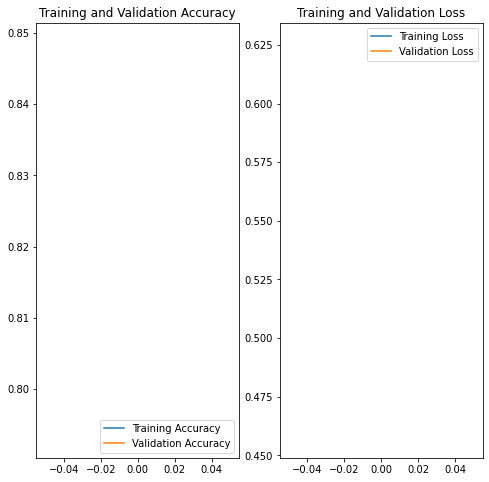

435/435 [==============================] - 23s 42ms/step - loss: 0.4472 - accuracy: 0.8529
Test Accuracy: 0.853


In [ ]:
# rollback to the best model
plot_stats(history, early_stop.stopped_epoch+1)
model = keras.models.load_model(model_name)
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy: %.3f" % acc)

# Confusion Matrix

435/435 [==============================] - 22s 42ms/step


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93c1398e20>)

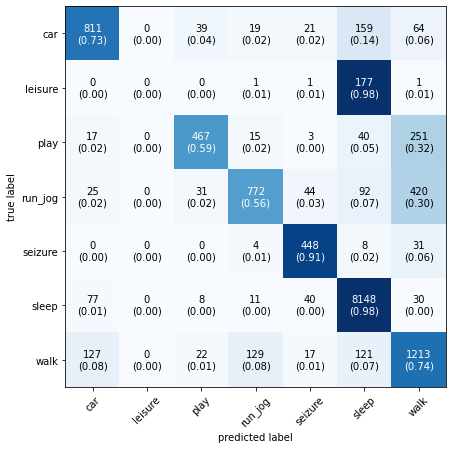

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=classes, show_normed=True, figsize=(7,7))

# Save the Model

In [ ]:
model.save(f'/content/drive/MyDrive/Smart Dog Collar/Models/BLSTM/{model_name}')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open( f'/content/drive/MyDrive/Smart Dog Collar/TFLModels/basic_blstm.tflite' , 'wb' ) as f:
  f.write(tflite_model)